# Example `Dysmalpy` Multi-Observation Fitting

This notebook shows the user how to do multi-observation fitting (either from data at different spatial resolution or at different wavelength ranges).

**Includes the following components:**

 - Disk + Bulge
 - NFW halo
 - Constant velocity dispersion

## Setup steps ##

**Import modules**

In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

import dysmalpy
from dysmalpy import galaxy
from dysmalpy import models
from dysmalpy import fitting
from dysmalpy import instrument
from dysmalpy import data_classes
from dysmalpy import parameters
from dysmalpy import plotting
from dysmalpy import aperture_classes
from dysmalpy import observation
from dysmalpy import config

import os
import copy

import numpy as np
import astropy.units as u
import astropy.io.fits as fits

INFO:numexpr.utils:Note: NumExpr detected 10 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
# A check for compatibility:
import emcee
if int(emcee.__version__[0]) >= 3:
    ftype_sampler = 'h5'
else:
    ftype_sampler = 'pickle'

**Setup notebook**

In [3]:
# Setup plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rcParams['figure.dpi']= 100
mpl.rc("savefig", dpi=300)

from IPython.core.display import Image

In [4]:
import logging
logger = logging.getLogger('DysmalPy')
logger.setLevel(logging.INFO)

**Set data, output paths**

In [5]:
# Data directory
dir_path = os.path.abspath(fitting.__path__[0])
data_dir = os.sep.join([os.sep.join(dir_path.split(os.sep)[:-1]),'tests', 'test_data', ''])
#'/YOUR/DATA/PATH/'
print(data_dir)

# Where to save output files
#outdir = '/Users/sedona/data/dysmalpy_test_examples/JUPYTER_OUTPUT_1D_multiobs/'
outdir = '/Users/jespejo/Dropbox/Postdoc/Data/dysmalpy_test_examples/JUPYTER_OUTPUT_1D_multiobs/'
#outdir = '/Users/ttshimiz/Dropbox/Research/DYSMALPY/dev/JUPYTER_OUTPUT_1D_multiobs/'

/Users/jespejo/anaconda3/envs/test_dysmalpy/lib/python3.11/site-packages/dysmalpy/tests/test_data/


-------------------

**Load the function to tie the scale height to the disk effective radius**

In [6]:
from dysmalpy.fitting_wrappers.tied_functions import tie_sigz_reff

**Load the function to tie Mvirial to $f_{DM}(R_e)$**

In [7]:
from dysmalpy.fitting_wrappers.tied_functions import tie_lmvirial_NFW

:::{admonition} Info
Also see **fitting_wrappers.tied_functions** for more tied functions
:::

**Load the function to tie the two geometries together**

In [8]:
from dysmalpy.fitting_wrappers.tied_functions import tied_geom_lambda

----------

## Initialize galaxy, model set, instrument

In [9]:
gal = galaxy.Galaxy(z=1.4, name='EGS4_24985')
mod_set = models.ModelSet()

### Baryonic component: Combined Disk+Bulge

In [10]:
total_mass = 11.0    # M_sun
bt = 0.3             # Bulge-Total ratio
r_eff_disk = 4.0     # kpc
n_disk = 1.0
invq_disk = 5.0
r_eff_bulge = 1.0    # kpc
n_bulge = 4.0
invq_bulge = 1.0
noord_flat = True    # Switch for applying Noordermeer flattening

# Fix components
bary_fixed = {'total_mass': False,
              'r_eff_disk': False, #True,
              'n_disk': True,
              'r_eff_bulge': True,
              'n_bulge': True,
              'bt': True}

# Set bounds
bary_bounds = {'total_mass': (10, 13),
               'r_eff_disk': (1.0, 30.0),
               'n_disk': (1, 8),
               'r_eff_bulge': (1, 5),
               'n_bulge': (1, 8),
               'bt': (0, 1)}

bary = models.DiskBulge(total_mass=total_mass, bt=bt,
                        r_eff_disk=r_eff_disk, n_disk=n_disk,
                        invq_disk=invq_disk,
                        r_eff_bulge=r_eff_bulge, n_bulge=n_bulge,
                        invq_bulge=invq_bulge,
                        noord_flat=noord_flat,
                        name='disk+bulge',
                        fixed=bary_fixed, bounds=bary_bounds)

bary.r_eff_disk.prior = parameters.BoundedGaussianPrior(center=5.0, stddev=1.0)

### Halo component

In [11]:
mvirial = 12.5
conc = 4.4
fdm = 0.2

halo_fixed = {'mvirial': False,
              'conc': True, 
              'fdm':  False}
# Mvirial will be tied -- so must set 'fixed=False' for Mvirial...

halo_bounds = {'mvirial': (10, 13),
               'conc': (1, 20),
               'fdm': (0, 1)}

halo = models.NFW(mvirial=mvirial, conc=conc, fdm=fdm, z=gal.z,
                  fixed=halo_fixed, bounds=halo_bounds, name='halo')


halo.mvirial.tied = tie_lmvirial_NFW

### Dispersion profile

In [12]:
sigma0 = 20.   # km/s
disp_fixed = {'sigma0': False}
disp_bounds = {'sigma0': (5, 300)}

disp_prof_halpha = models.DispersionConst(sigma0=sigma0, fixed=disp_fixed,
                                          bounds=disp_bounds, name='dispprof_Ha', tracer='halpha')
disp_prof_co = models.DispersionConst(sigma0=sigma0, fixed=disp_fixed,
                                          bounds=disp_bounds, name='dispprof_CO', tracer='co')

### z-height profile

In [13]:
sigmaz = 0.9   # kpc
zheight_fixed = {'sigmaz': False}

zheight_prof = models.ZHeightGauss(sigmaz=sigmaz, name='zheightgaus',
                                   fixed=zheight_fixed)
zheight_prof.sigmaz.tied = tie_sigz_reff

### Geometry

In [14]:
inc = 44.     # degrees
pa = 142.     # degrees, blue-shifted side CCW from north
xshift = 0    # pixels from center
yshift = 0    # pixels from center
vel_shift = 0 # velocity shift at center ; km/s
geom_fixed = {'inc': False,
              'pa': True,
              'xshift': True,
              'yshift': True,
              'vel_shift': True}

geom_bounds = {'inc': (30, 60),
               'pa': (132, 152),
               'xshift': (-2.5, 2.5),
               'yshift': (-2.5, 2.5),
               'vel_shift': (-100, 100)}

geom_halpha = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift, vel_shift=vel_shift, 
                       fixed=geom_fixed, bounds=geom_bounds, 
                       name='geom_halpha', obs_name='Halpha')

geom_co = models.Geometry(inc=inc, pa=pa, xshift=xshift, yshift=yshift, vel_shift=vel_shift, 
                       fixed=geom_fixed, bounds=geom_bounds, 
                       name='geom_co', obs_name='CO')

geom_co.inc.tied = tied_geom_lambda('geom_halpha', 'inc')

### Add all model components to ModelSet

In [15]:
# Add all of the model components to the ModelSet
mod_set.add_component(bary, light=True)
mod_set.add_component(halo)
mod_set.add_component(disp_prof_halpha)
mod_set.add_component(disp_prof_co)
mod_set.add_component(zheight_prof)
mod_set.add_component(geom_halpha)
mod_set.add_component(geom_co)

### Set kinematic options for calculating velocity profile

In [16]:
mod_set.kinematic_options.adiabatic_contract = False
mod_set.kinematic_options.pressure_support = True

### Set up the observation and instrument

In [17]:
# Halpha observations
obs_halpha = observation.Observation(name='Halpha', tracer='halpha')

inst_halpha = instrument.Instrument()

beamsize = 0.7*u.arcsec                 # FWHM of beam
sig_inst = 45*u.km/u.s                   # Instrumental spectral resolution

beam = instrument.GaussianBeam(major=beamsize)
lsf = instrument.LSF(sig_inst)

inst_halpha.beam = beam
inst_halpha.lsf = lsf
inst_halpha.pixscale = 0.25*u.arcsec           # arcsec/pixel
inst_halpha.fov = [27, 27]                      # (nx, ny) pixels
inst_halpha.spec_type = 'velocity'              # 'velocity' or 'wavelength'
inst_halpha.spec_step = 10*u.km/u.s             # Spectral step
inst_halpha.spec_start = -1000*u.km/u.s         # Starting value of spectrum
inst_halpha.nspec = 201                         # Number of spectral pixels

# Set the beam kernel so it doesn't have to be calculated every step
inst_halpha.set_beam_kernel()
inst_halpha.set_lsf_kernel()

# Extraction information
inst_halpha.ndim = 1                            # Dimensionality of data
inst_halpha.moment = False                      # For 1D/2D data, if True then velocities and dispersion calculated from moments
                                         # Default is False, meaning Gaussian extraction used

# Add instrument to observation
obs_halpha.instrument = inst_halpha

In [18]:
# CO Observations
obs_co = observation.Observation(name='CO', tracer='co')

inst_co = instrument.Instrument()

beamsize = 0.6*u.arcsec                 # FWHM of beam
sig_inst = 19*u.km/u.s                   # Instrumental spectral resolution

beam = instrument.GaussianBeam(major=beamsize)
lsf = instrument.LSF(sig_inst)

inst_co.beam = beam
inst_co.lsf = lsf
inst_co.pixscale = 0.25*u.arcsec           # arcsec/pixel
inst_co.fov = [27, 27]                      # (nx, ny) pixels
inst_co.spec_type = 'velocity'              # 'velocity' or 'wavelength'
inst_co.spec_step = 10*u.km/u.s             # Spectral step
inst_co.spec_start = -1000*u.km/u.s         # Starting value of spectrum
inst_co.nspec = 201                         # Number of spectral pixels

# Set the beam kernel so it doesn't have to be calculated every step
inst_co.set_beam_kernel()
inst_co.set_lsf_kernel()

# Extraction information
inst_co.ndim = 1                            # Dimensionality of data
inst_co.moment = False                      # For 1D/2D data, if True then velocities and dispersion calculated from moments
                                         # Default is False, meaning Gaussian extraction used

# Add instrument to observation
obs_co.instrument = inst_co

### Load data

* Load the data from file:
  - *1D velocity, dispersion profiles and error*
  - *A mask can be loaded / created as well*
  
* Put data in `Data1D` class

* Add data to Observation object

In [19]:
# Halpha Data
f_data_1d = data_dir+'EGS4_24985_Ha_1D_profile.dat'
dat_arr = np.loadtxt(f_data_1d)
gs4_r = dat_arr[:,0]
gs4_vel = dat_arr[:,1]
gs4_disp = dat_arr[:,3]
err_vel = dat_arr[:,2]
err_disp = dat_arr[:,4]
inst_corr = True                  # Flag for if the measured dispersion has been
                                  # corrected for instrumental resolution
    
# Put data in Data1D data class: 
data1d_halpha = data_classes.Data1D(r=gs4_r, velocity=gs4_vel,
                                  vel_disp=gs4_disp, vel_err=err_vel,
                                  vel_disp_err=err_disp, inst_corr=inst_corr, 
                                  filename_velocity=f_data_1d)

# Add data to Observation:
obs_halpha.data = data1d_halpha

In [20]:
# CO Data
f_data_1d = data_dir+'EGS4_24985_CO_1D_profile.dat'
dat_arr = np.loadtxt(f_data_1d)
gs4_r = dat_arr[:,0]
gs4_vel = dat_arr[:,1]
gs4_disp = dat_arr[:,3]
err_vel = dat_arr[:,2]
err_disp = dat_arr[:,4]
inst_corr = True                  # Flag for if the measured dispersion has been
                                  # corrected for instrumental resolution
    
# Put data in Data1D data class: 
data1d_co = data_classes.Data1D(r=gs4_r, velocity=gs4_vel,
                                  vel_disp=gs4_disp, vel_err=err_vel,
                                  vel_disp_err=err_disp, inst_corr=inst_corr, 
                                  filename_velocity=f_data_1d)

# Add data to Observation:
obs_co.data = data1d_co

### Setup apertures:

In [21]:
# Halpha Data

profile1d_type = 'circ_ap_cube'    # Extraction in circular apertures placed on the cube

aperture_radius = 0.5 * obs_halpha.instrument.beam.major.value

obs_halpha.instrument.apertures = aperture_classes.setup_aperture_types(obs=obs_halpha, 
                profile1d_type=profile1d_type, 
                aper_centers=obs_halpha.data.rarr,
                slit_pa=pa, slit_width=beamsize.value,
                aperture_radius=aperture_radius, 
                partial_weight=True)

In [22]:
# CO Data

profile1d_type = 'circ_ap_cube'    # Extraction in circular apertures placed on the cube

aperture_radius = 0.5 * obs_co.instrument.beam.major.value

obs_co.instrument.apertures = aperture_classes.setup_aperture_types(obs=obs_co, 
                profile1d_type=profile1d_type, 
                aper_centers=obs_co.data.rarr,
                slit_pa=pa, slit_width=beamsize.value,
                aperture_radius=aperture_radius, 
                partial_weight=True)

In [23]:
# INCOMPLETE BELOW HERE!!!

### Define model, fit options:

In [24]:
obs_halpha.mod_options.oversample = 1  
# Factor by which to oversample model (eg, subpixels)

obs_halpha.fit_options.fit = True             # Include this observation in the fit (T/F)
obs_halpha.fit_options.fit_velocity = True    # 1D/2D: Fit velocity of observation (T/F)
obs_halpha.fit_options.fit_dispersion = True  # 1D/2D: Fit dispersion of observation (T/F)
obs_halpha.fit_options.fit_flux = False       # 1D/2D: Fit flux of observation (T/F)

In [25]:
obs_co.mod_options.oversample = 1  
# Factor by which to oversample model (eg, subpixels)

obs_co.fit_options.fit = True             # Include this observation in the fit (T/F)
obs_co.fit_options.fit_velocity = True    # 1D/2D: Fit velocity of observation (T/F)
obs_co.fit_options.fit_dispersion = True  # 1D/2D: Fit dispersion of observation (T/F)
obs_co.fit_options.fit_flux = False       # 1D/2D: Fit flux of observation (T/F)

### Add the model set, observation to the Galaxy

In [26]:
gal.model = mod_set
gal.add_observation(obs_halpha)
gal.add_observation(obs_co)

-----------------

## MPFIT Fitting

**Set up ``MPFITFitter`` fitter with fitting parameters**

In [27]:
# Options passed to MPFIT:
maxiter = 200

fitter = fitting.MPFITFitter(maxiter=maxiter)

**Set up fit/plot output options**

In [28]:
# Output directory
outdir_mpfit = outdir+'MPFIT/'

# Output options: 
do_plotting = True  
plot_type = 'png'
overwrite = True

output_options = config.OutputOptions(outdir=outdir_mpfit, 
                                      do_plotting=do_plotting, 
                                      plot_type=plot_type,
                                      overwrite=overwrite)

**Run `Dysmalpy` fitting: MPFIT**

In [29]:
mpfit_results = fitter.fit(gal, output_options)

INFO:DysmalPy:*************************************
INFO:DysmalPy: Fitting: EGS4_24985 using MPFIT
INFO:DysmalPy:    obs: Halpha
INFO:DysmalPy:        velocity file: /Users/jespejo/anaconda3/envs/test_dysmalpy/lib/python3.11/site-packages/dysmalpy/tests/test_data/EGS4_24985_Ha_1D_profile.dat
INFO:DysmalPy:        nSubpixels: 1
INFO:DysmalPy:    obs: CO
INFO:DysmalPy:        velocity file: /Users/jespejo/anaconda3/envs/test_dysmalpy/lib/python3.11/site-packages/dysmalpy/tests/test_data/EGS4_24985_CO_1D_profile.dat
INFO:DysmalPy:        nSubpixels: 1
INFO:DysmalPy:    mvirial_tied: <function tie_lmvirial_NFW at 0x29004dda0>
INFO:DysmalPy:
MPFIT Fitting:
Start: 2024-05-02 11:05:35.429014

INFO:DysmalPy:Iter 1  CHI-SQUARE = 176.6227473  DOF = 56
   disk+bulge:total_mass = 11  
   disk+bulge:r_eff_disk = 4  
   halo:fdm = 0.2  
   dispprof_Ha:sigma0 = 20  
   dispprof_CO:sigma0 = 20  
   geom_halpha:inc = 44  

INFO:DysmalPy:Iter 2  CHI-SQUARE = 108.2563478  DOF = 56
   disk+bulge:total_mas

### Examine MPFIT results

#### Result plots

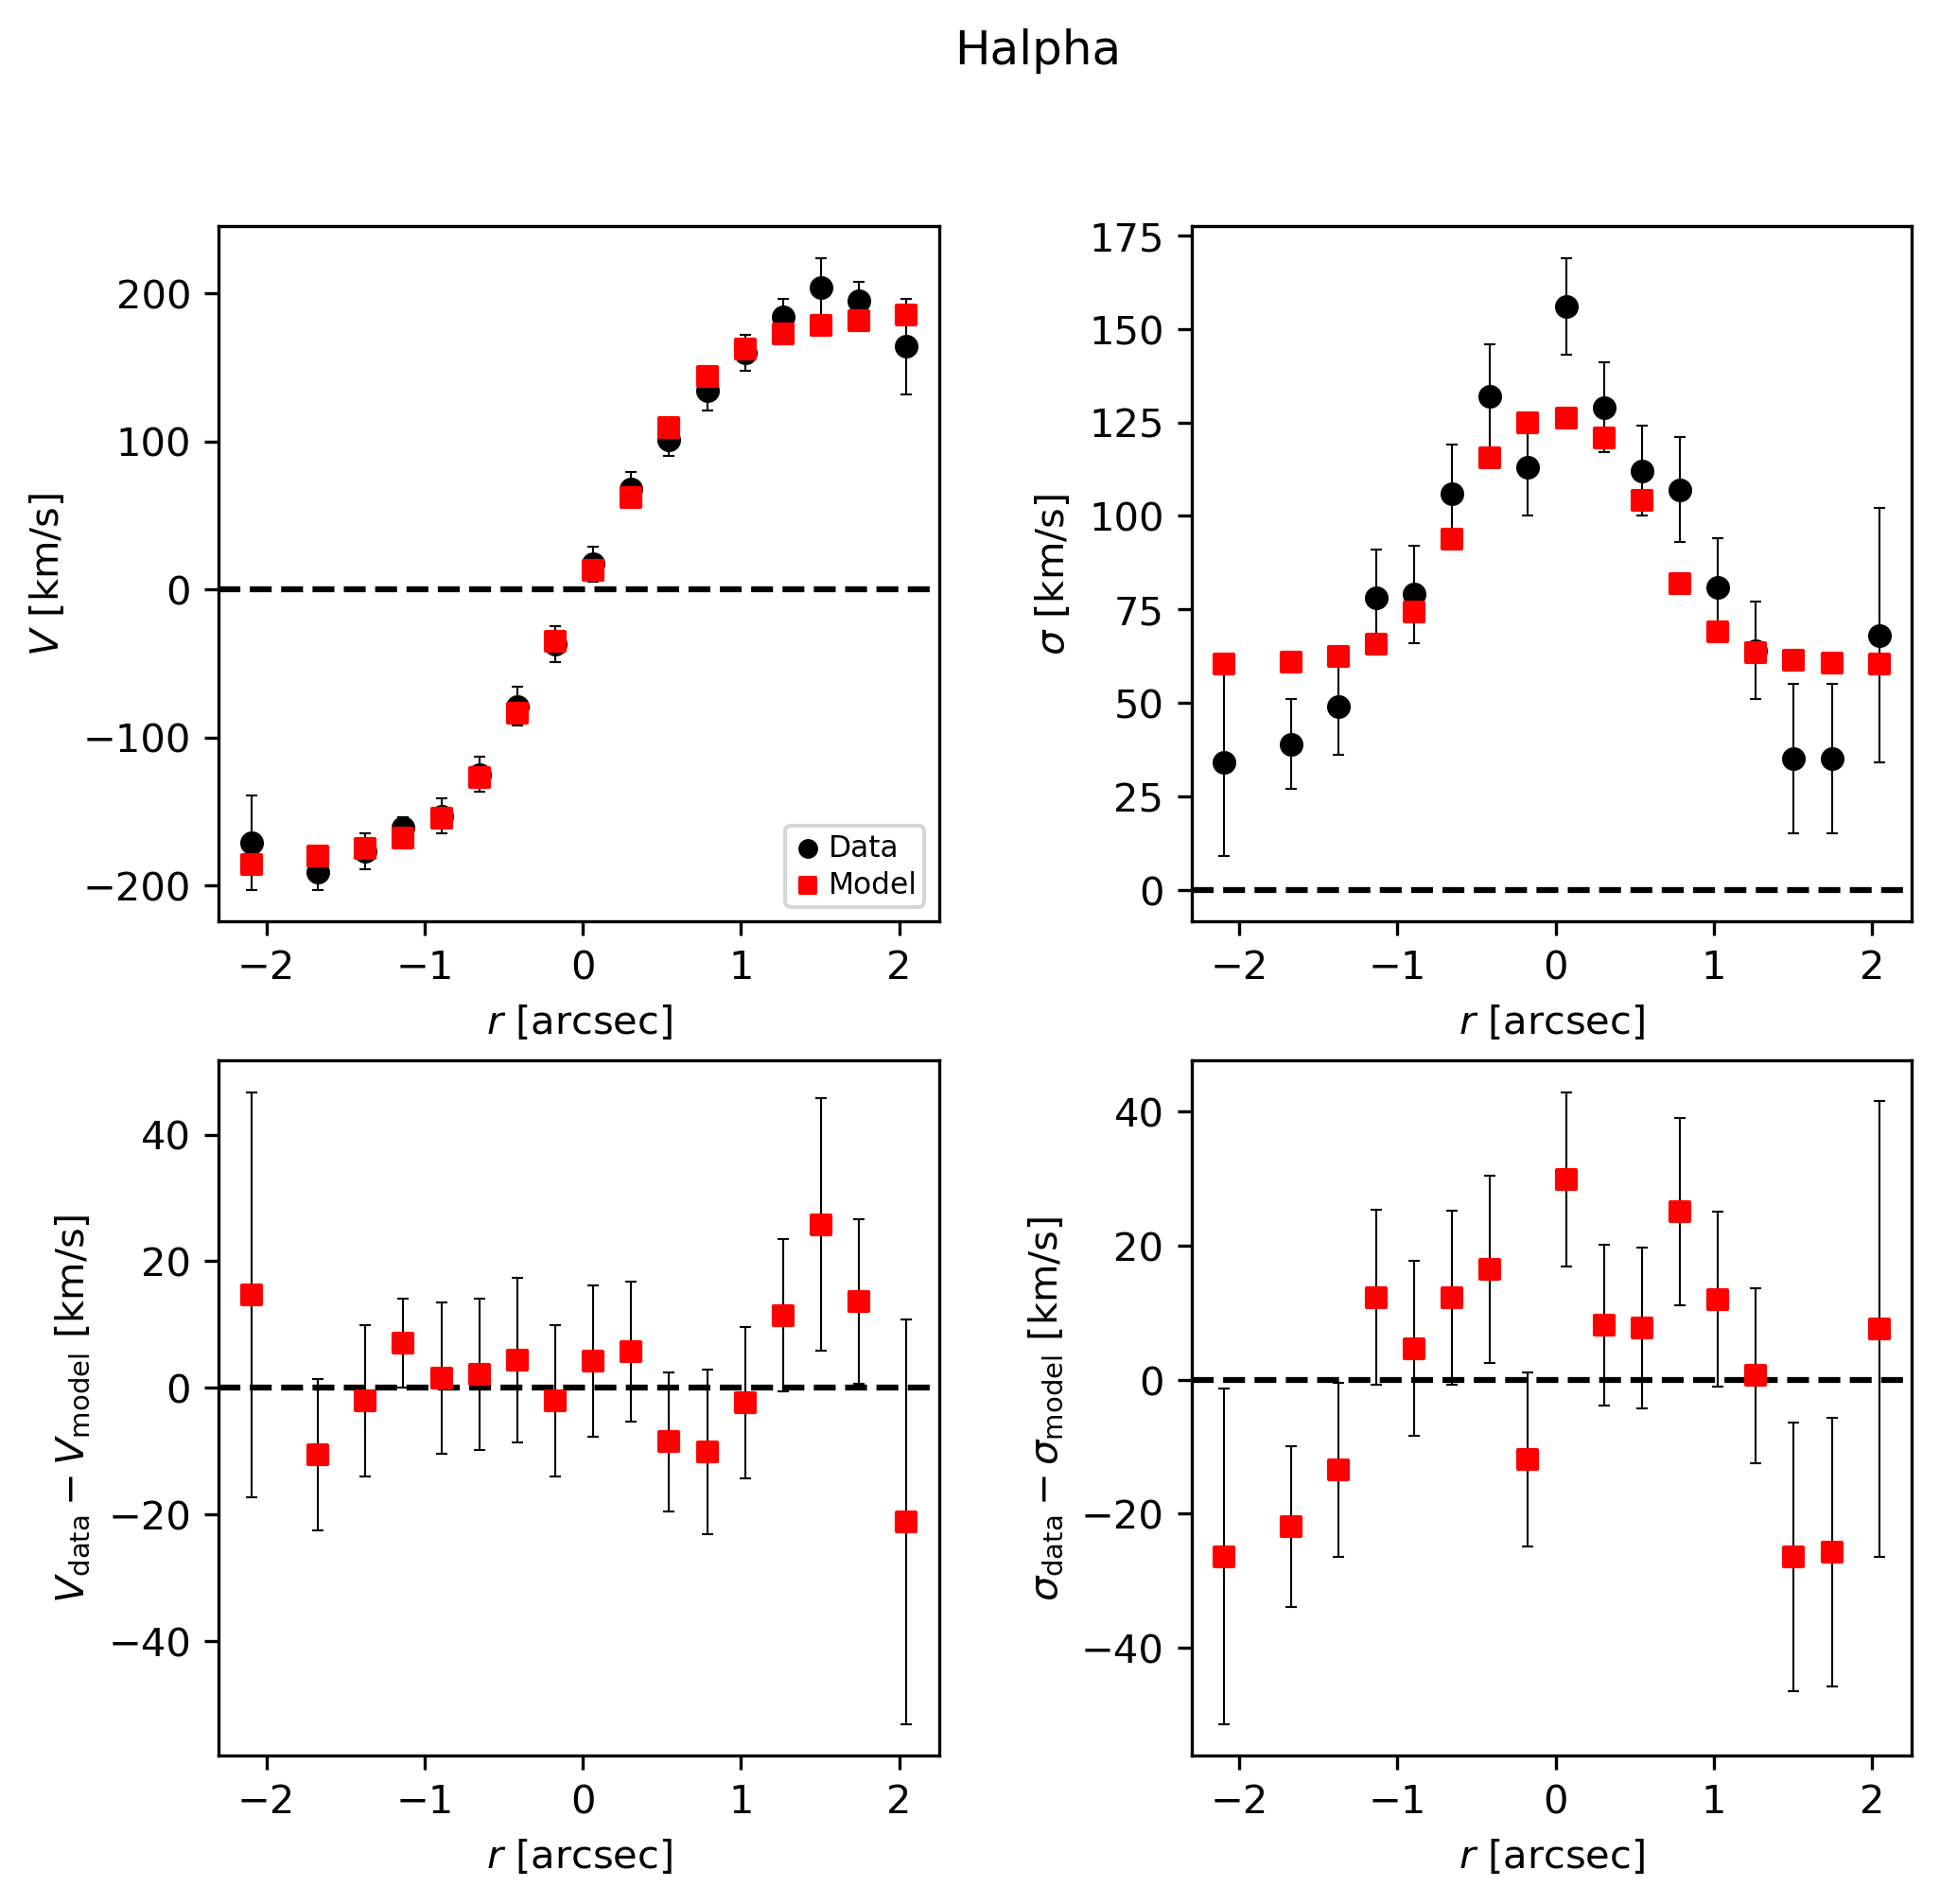

In [30]:
# Look at best-fit for Halpha:
filepath = outdir_mpfit+"EGS4_24985_mpfit_bestfit_Halpha.{}".format(plot_type)
Image(filename=filepath, width=600)

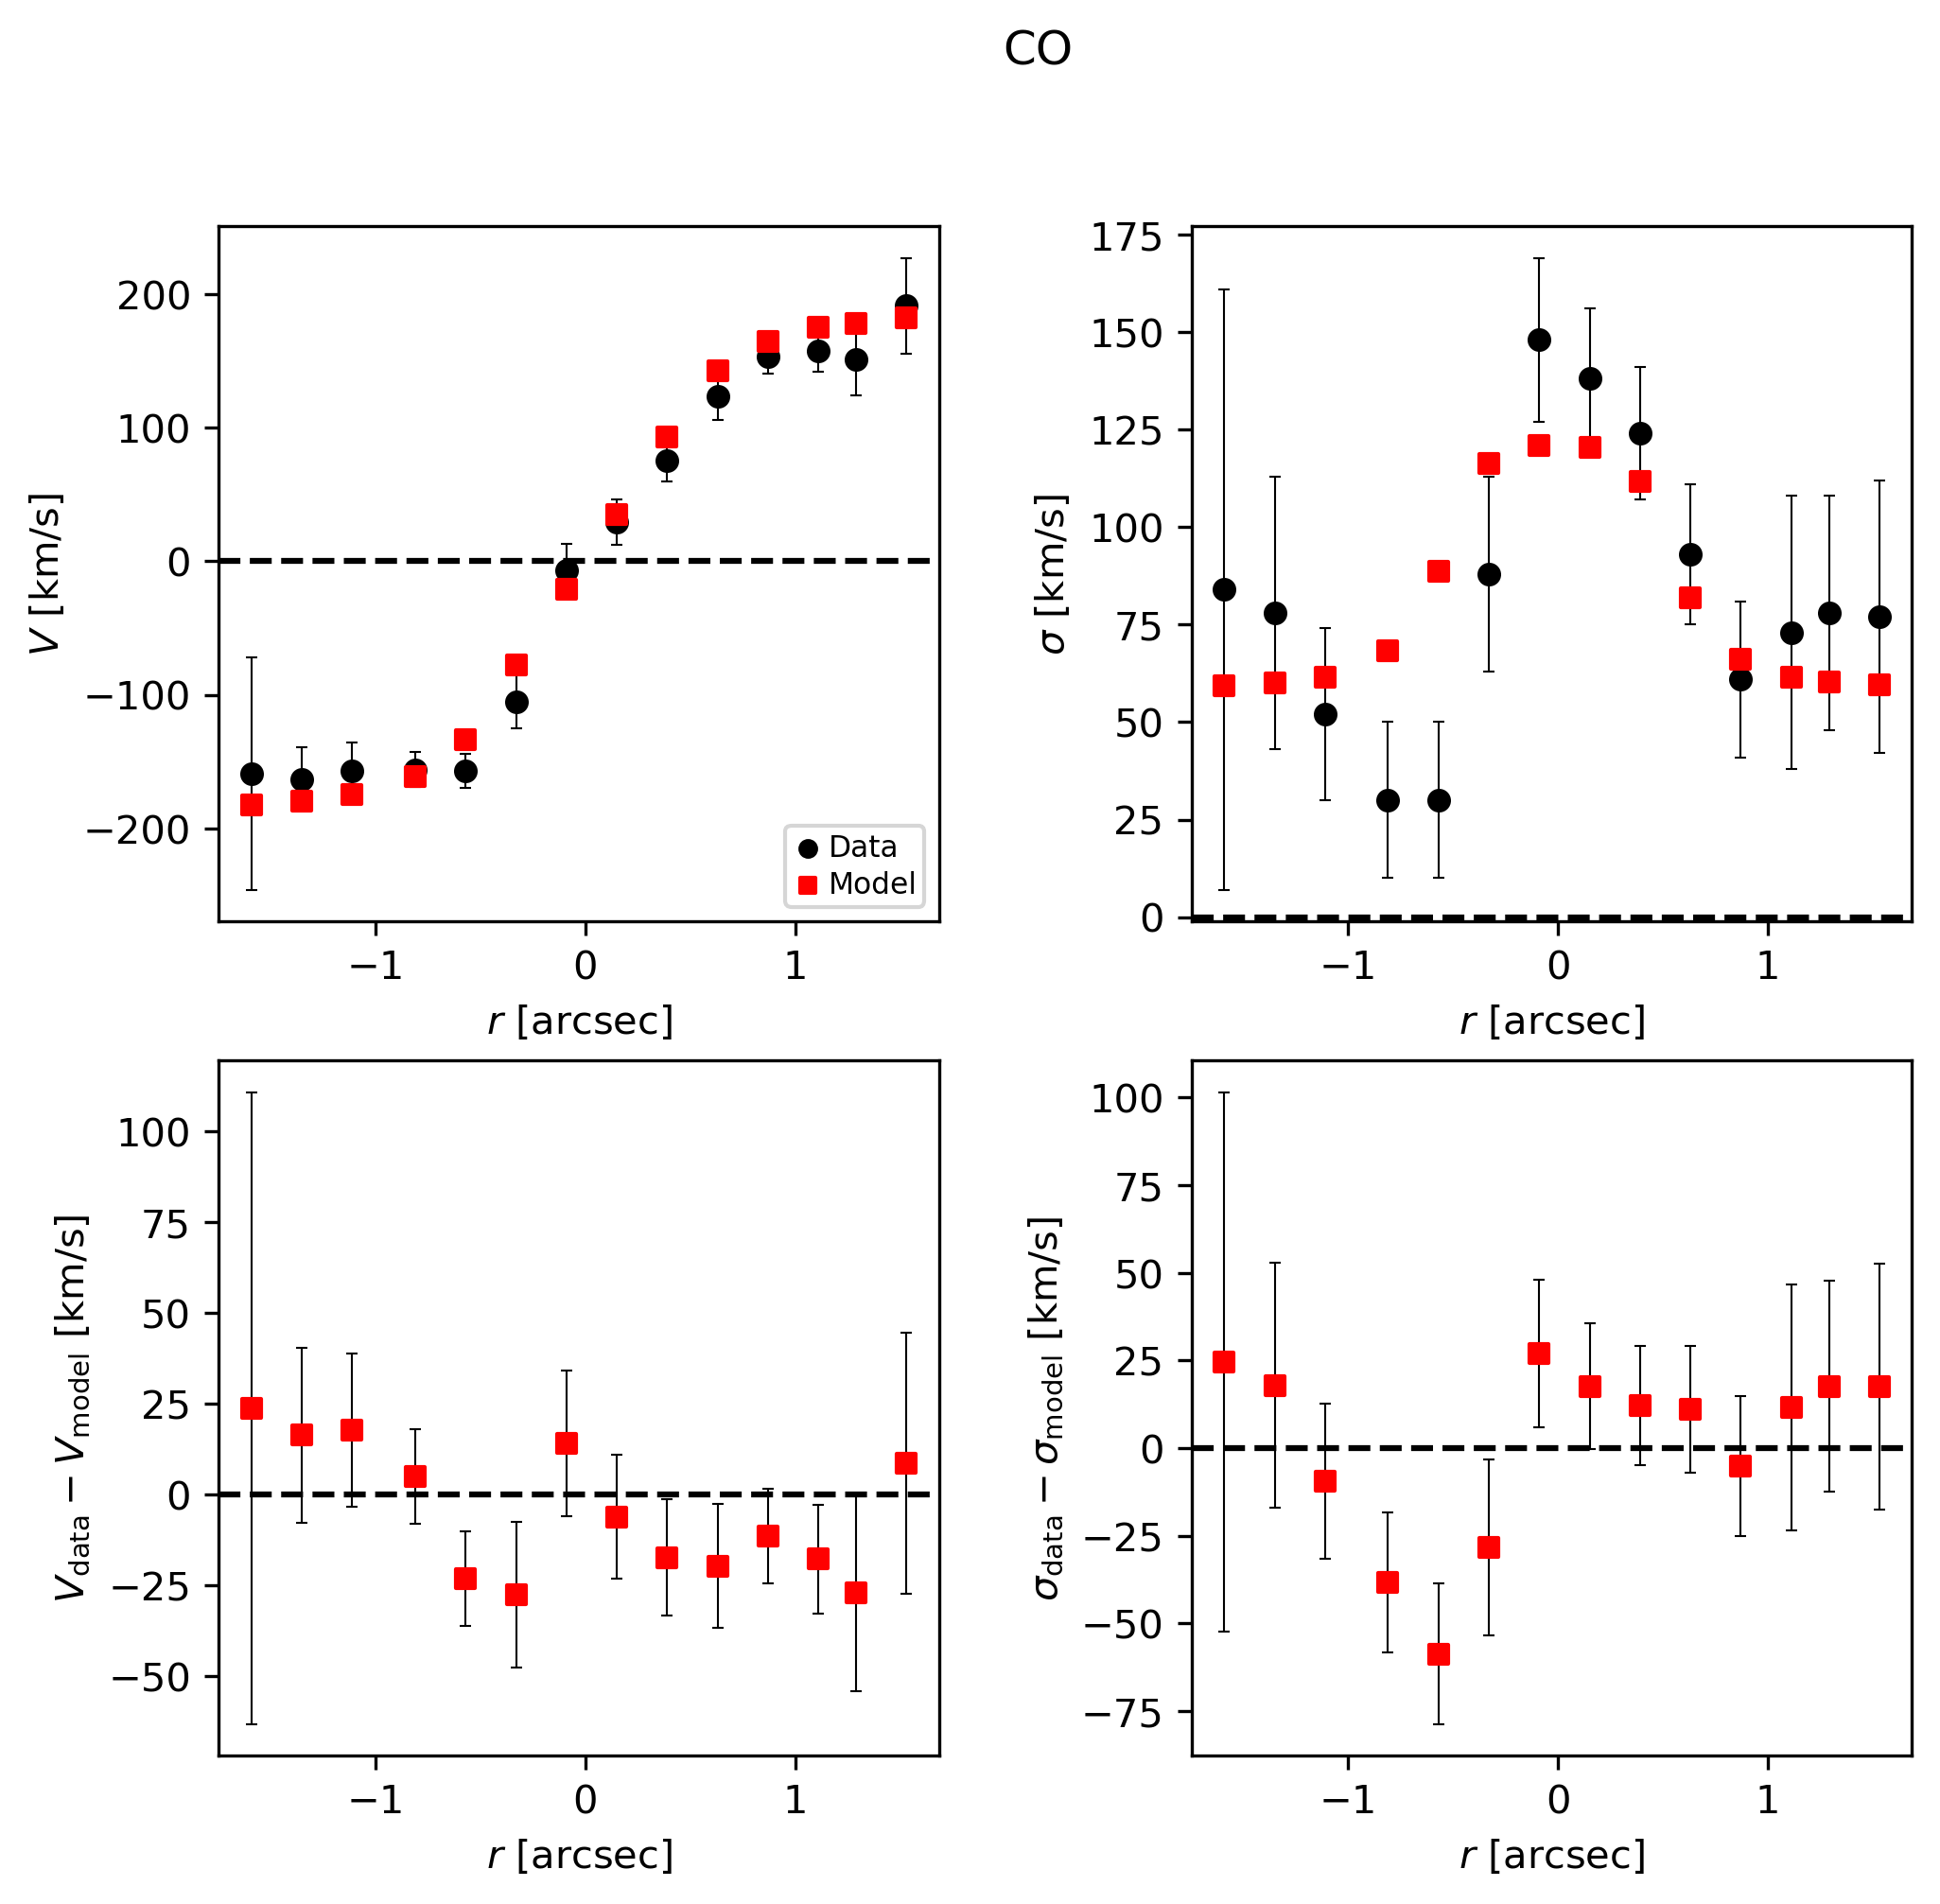

In [31]:
# Look at best-fit for CO:
filepath = outdir_mpfit+"EGS4_24985_mpfit_bestfit_CO.{}".format(plot_type)
Image(filename=filepath, width=600)

#### Directly generating result plots ####

**Reload the galaxy, results files:**

In [32]:
f_galmodel =       outdir_mpfit + 'EGS4_24985_model.pickle'
f_mpfit_results =  outdir_mpfit + 'EGS4_24985_mpfit_results.pickle'

gal, mpfit_results = fitting.reload_all_fitting(filename_galmodel=f_galmodel, 
                            filename_results=f_mpfit_results, fit_method='mpfit')

**Plot the best-fit results:**

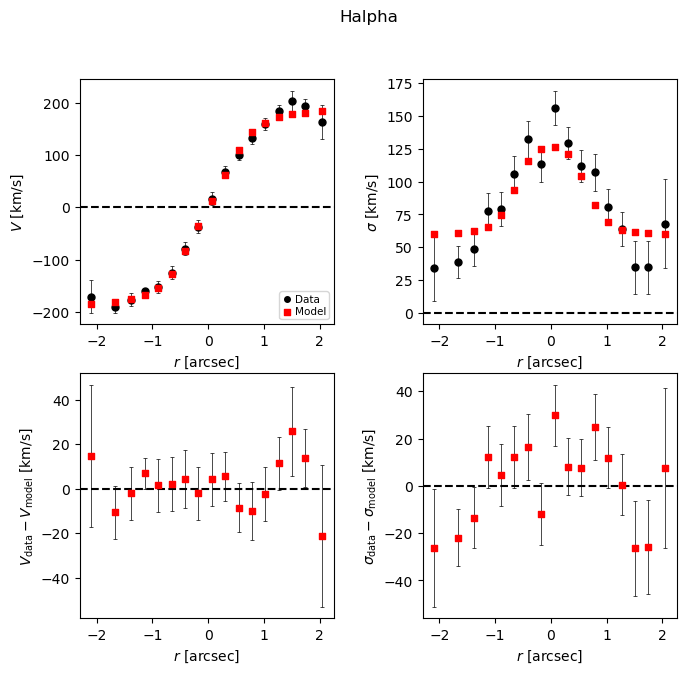

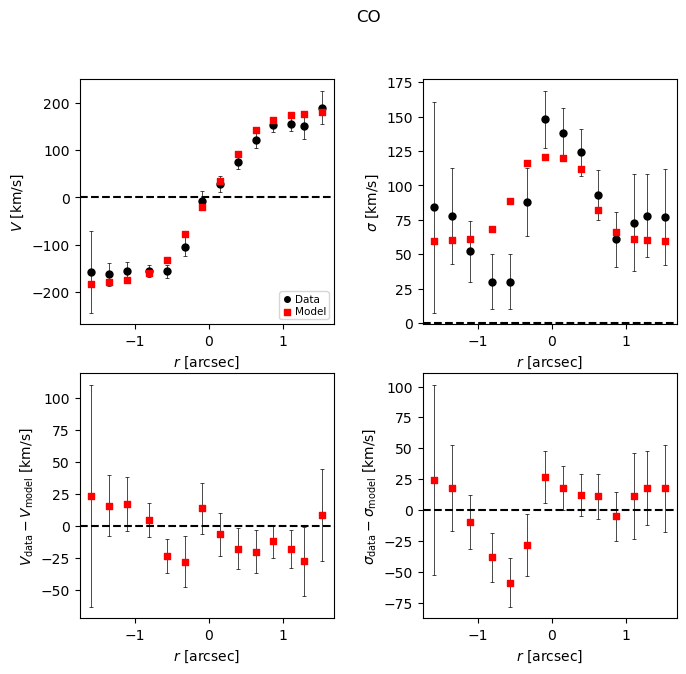

In [33]:
mpfit_results.plot_results(gal)

#### Result reports

We now look at the results reports, which include the best-fit values and uncertainties (as well as other fitting settings and output).

In [34]:
# Print report
print(mpfit_results.results_report(gal=gal))

###############################
 Fitting for EGS4_24985

Date: 2024-05-02 11:05:45.922469

    obs: Halpha
         Datafiles:
             vel :  /Users/jespejo/anaconda3/envs/test_dysmalpy/lib/python3.11/site-packages/dysmalpy/tests/test_data/EGS4_24985_Ha_1D_profile.dat
         apertures:        CircApertures
         fit_velocity:           True
         fit_dispersion:         True
         fit_flux:               False
         moment:           False
         partial_weight:        True
         n_wholepix_z_min:      3
         oversample:            1
         oversize:              1

    obs: CO
         Datafiles:
             vel :  /Users/jespejo/anaconda3/envs/test_dysmalpy/lib/python3.11/site-packages/dysmalpy/tests/test_data/EGS4_24985_CO_1D_profile.dat
         apertures:        CircApertures
         fit_velocity:           True
         fit_dispersion:         True
         fit_flux:               False
         moment:           False
         partial_weight:     

**To <span style="color:DarkCyan">directly save</span> the results report** to a file, we can use the following:

(Note: by default, report files are saved as part of the fitting process)

In [35]:
# Save report to file:
f_mpfit_report = outdir_mpfit + 'mpfit_fit_report.txt'
mpfit_results.results_report(gal=gal, filename=f_mpfit_report)

-----------------

## MCMC Fitting

**Get a clean copy of model, obs**

In [36]:
# gal = galaxy.Galaxy(z=1.613, name='GS4_43501')

# obscopy = observation.Observation(name='halpha_2D', tracer='halpha')
# obscopy.data = copy.deepcopy(data2d)
# obscopy.instrument = copy.deepcopy(inst)
# obscopy.mod_options = copy.deepcopy(obs.mod_options)
# obscopy.fit_options = copy.deepcopy(obs.fit_options)

# gal.add_observation(obscopy)

gal.model = copy.deepcopy(mod_set)

**Set up ``MCMCFitter`` fitter with fitting parameters**

In [37]:
# Options passed to emcee
## SHORT TEST:
nWalkers = 30
nCPUs = 8
scale_param_a = 5 #3   
# The walkers were not exploring the parameter space well with scale_param_a = 3, 
#     but were getting 'stuck'. So to improve the walker movement with larger 
#     'stretch' in the steps, we increased scale_param_a.
nBurn = 5
nSteps = 30
minAF = None
maxAF = None
nEff = 10

blob_name = 'mvirial'    # Also save 'blob' values of Mvirial, calculated at every chain step


fitter = fitting.MCMCFitter(nWalkers=nWalkers, nCPUs=nCPUs, 
                            scale_param_a=scale_param_a, nBurn=nBurn, nSteps=nSteps, 
                            minAF=minAF, maxAF=maxAF, nEff=nEff, blob_name=blob_name)

**Set up fit/plot output options**

In [38]:
# Output directory
outdir_mcmc = outdir + 'MCMC/'

# Output options: 
do_plotting = True  
plot_type = 'png'
overwrite = True

output_options = config.OutputOptions(outdir=outdir_mcmc, 
                                      do_plotting=do_plotting, 
                                      plot_type=plot_type,
                                      overwrite=overwrite)

**Run `Dysmalpy` fitting: MCMC**

In [39]:
mcmc_results = fitter.fit(gal, output_options)

INFO:DysmalPy:*************************************
INFO:DysmalPy: Fitting: EGS4_24985 with MCMC
INFO:DysmalPy:    obs: Halpha
INFO:DysmalPy:        velocity file: /Users/jespejo/anaconda3/envs/test_dysmalpy/lib/python3.11/site-packages/dysmalpy/tests/test_data/EGS4_24985_Ha_1D_profile.dat
INFO:DysmalPy:        nSubpixels: 1
INFO:DysmalPy:    obs: CO
INFO:DysmalPy:        velocity file: /Users/jespejo/anaconda3/envs/test_dysmalpy/lib/python3.11/site-packages/dysmalpy/tests/test_data/EGS4_24985_CO_1D_profile.dat
INFO:DysmalPy:        nSubpixels: 1
INFO:DysmalPy:
nCPUs: 8
INFO:DysmalPy:nWalkers: 30
INFO:DysmalPy:lnlike: oversampled_chisq=True
INFO:DysmalPy:
blobs: mvirial
INFO:DysmalPy:
mvirial_tied: <function tie_lmvirial_NFW at 0x29004dda0>
INFO:DysmalPy:
Burn-in:
Start: 2024-05-02 11:05:46.911468

INFO:DysmalPy: k=0, time.time=2024-05-02 11:05:46.913041, a_frac=nan
INFO:DysmalPy: k=1, time.time=2024-05-02 11:05:48.531578, a_frac=0.3
INFO:DysmalPy: k=2, time.time=2024-05-02 11:05:49.11

### Examine MCMC results

Of course this (very short!) example looks terrible, but it's instructive to see what's happening even if you only did a very short / few walker MCMC test:

**Trace**
- The individual walkers should move around in the parameter space over the chain iterations (not necessarily for every step; but there should be ***some*** exploration of the space)

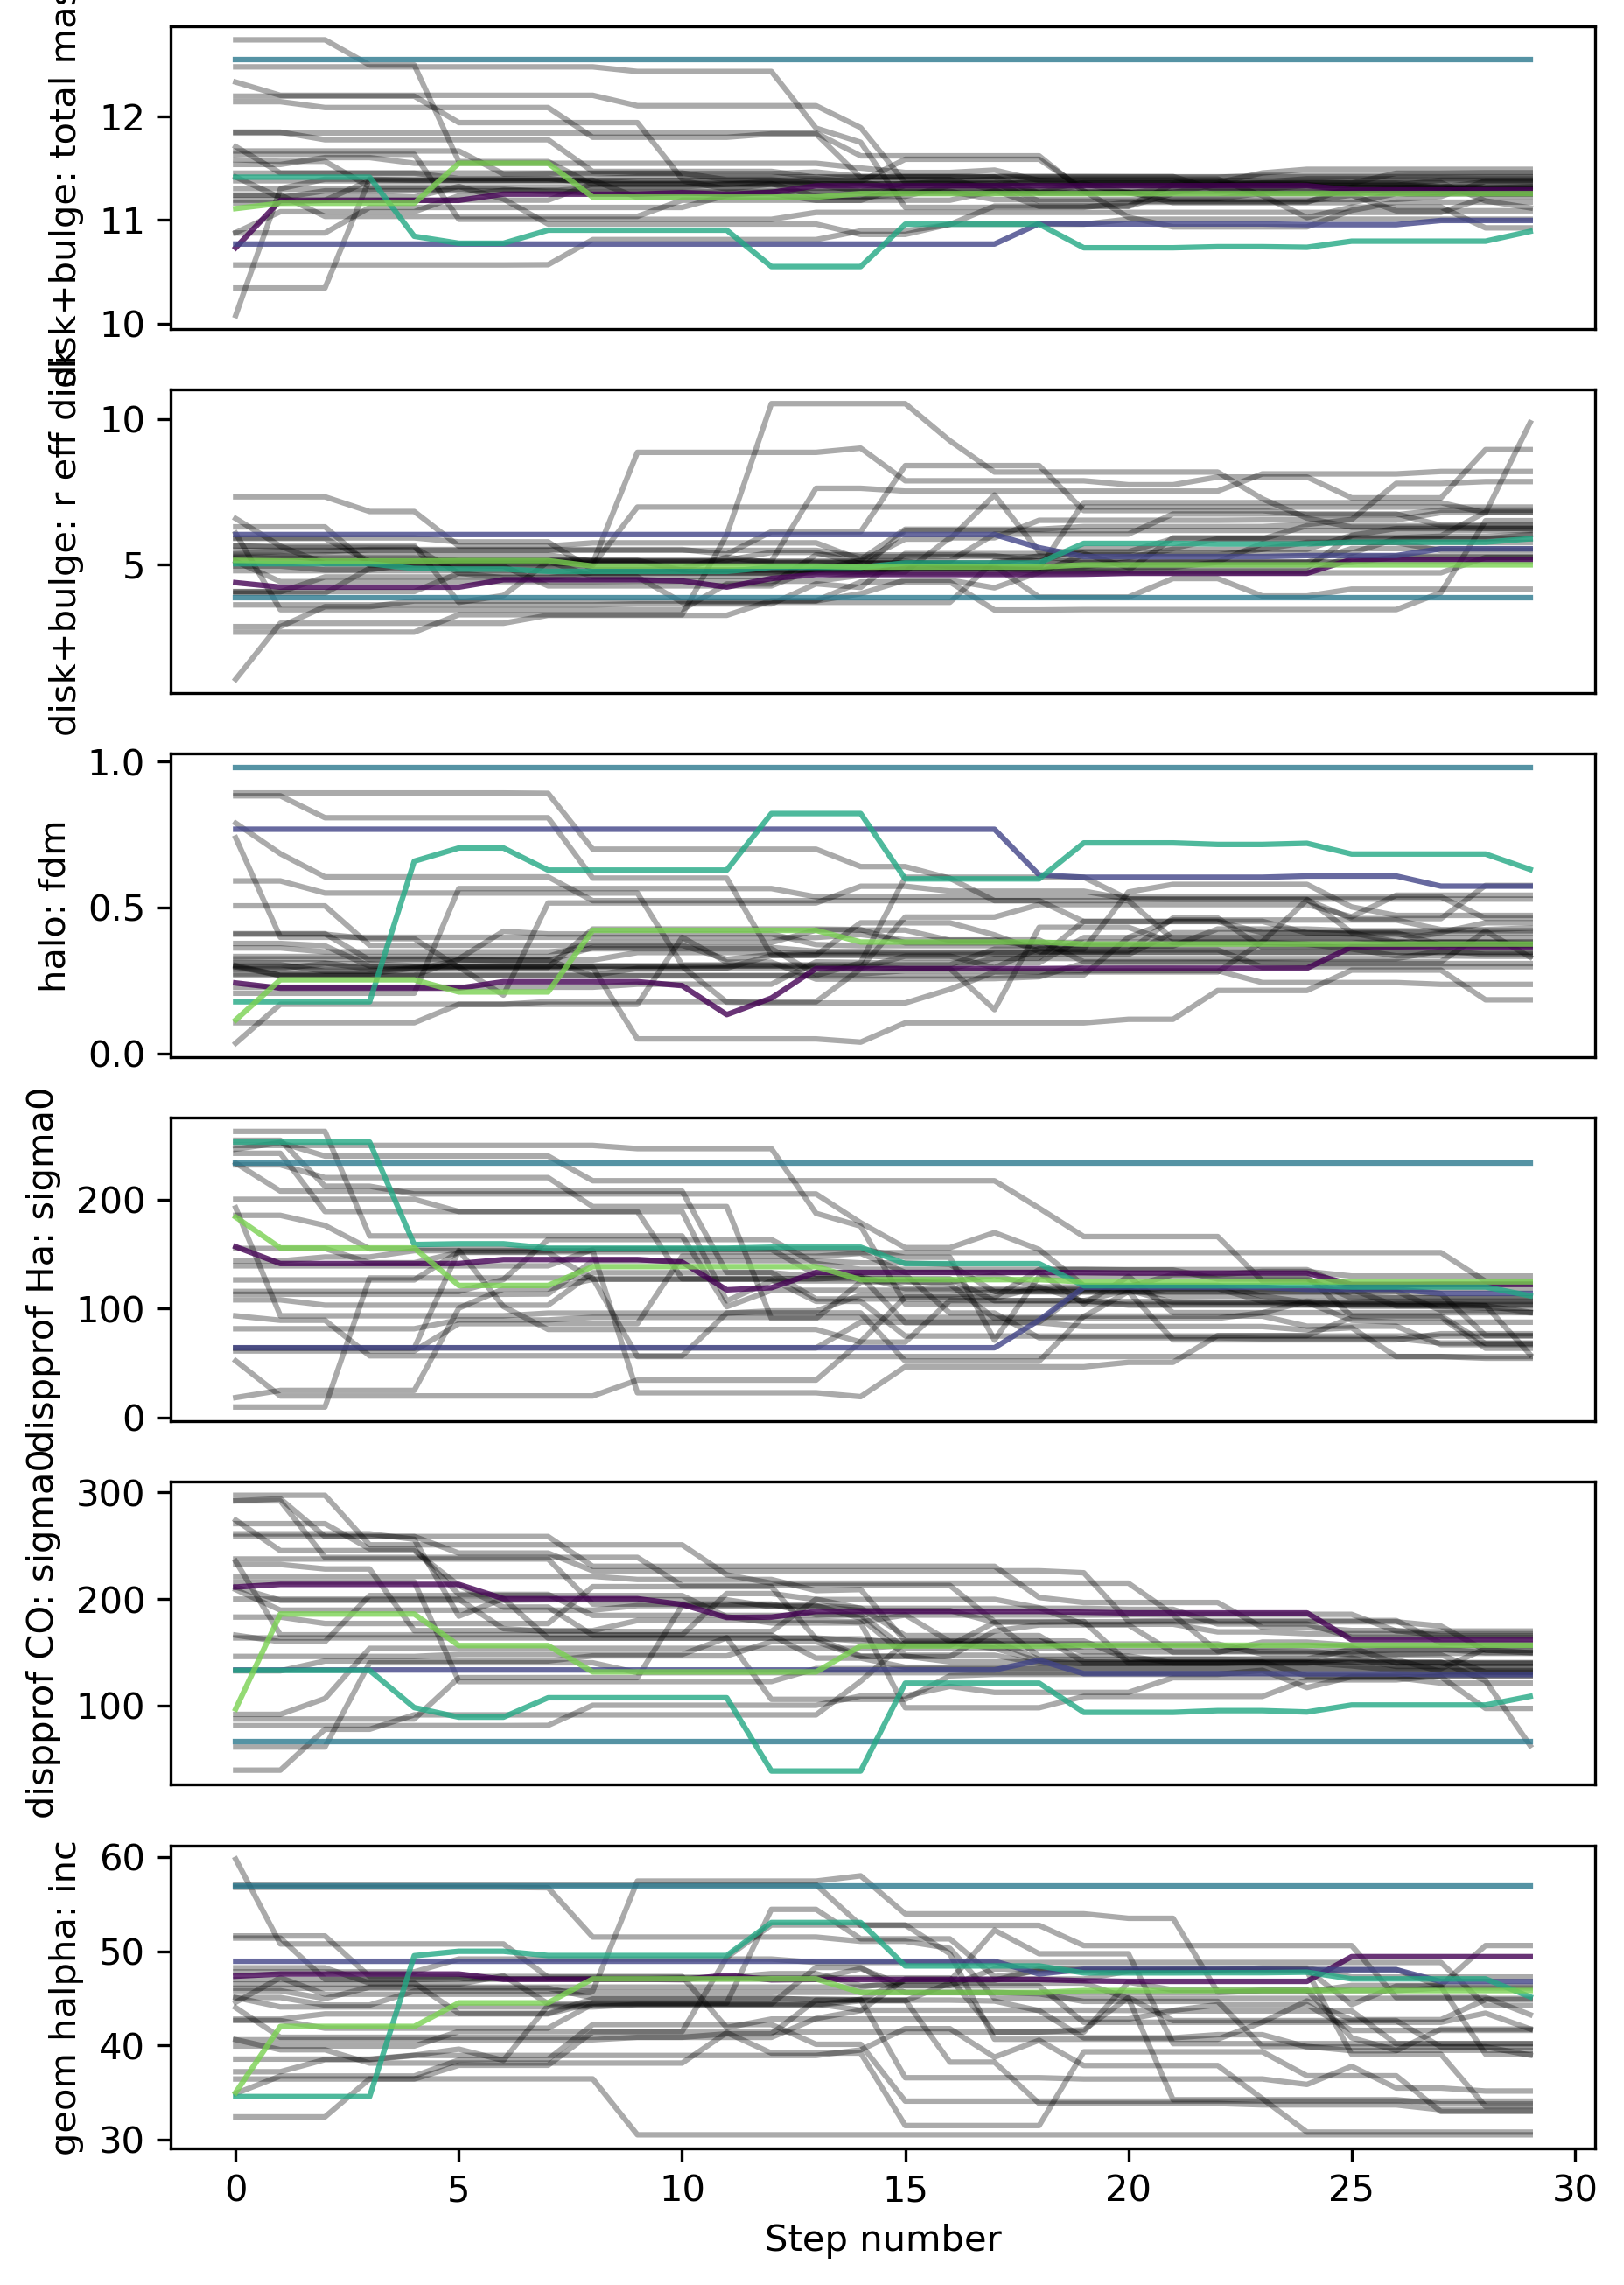

In [40]:
# Look at trace:
filepath = outdir_mcmc+"EGS4_24985_mcmc_trace.{}".format(plot_type)
Image(filepath, width=600)

**Best-fit**
- This is a good opportunity to check that the model PA and slit PA are correct, or else the data and model curves will have opposite shapes!
- Also, it's helpful to check that your data masking is reasonable.
- Finally, this is a worthwhile chance to see if your "nuisance" geometry and spectral parameters (especially `xshift`, `yshift`, `vel_shift` have reasonable values, and if appropriate, reasonable bounds and priors.)

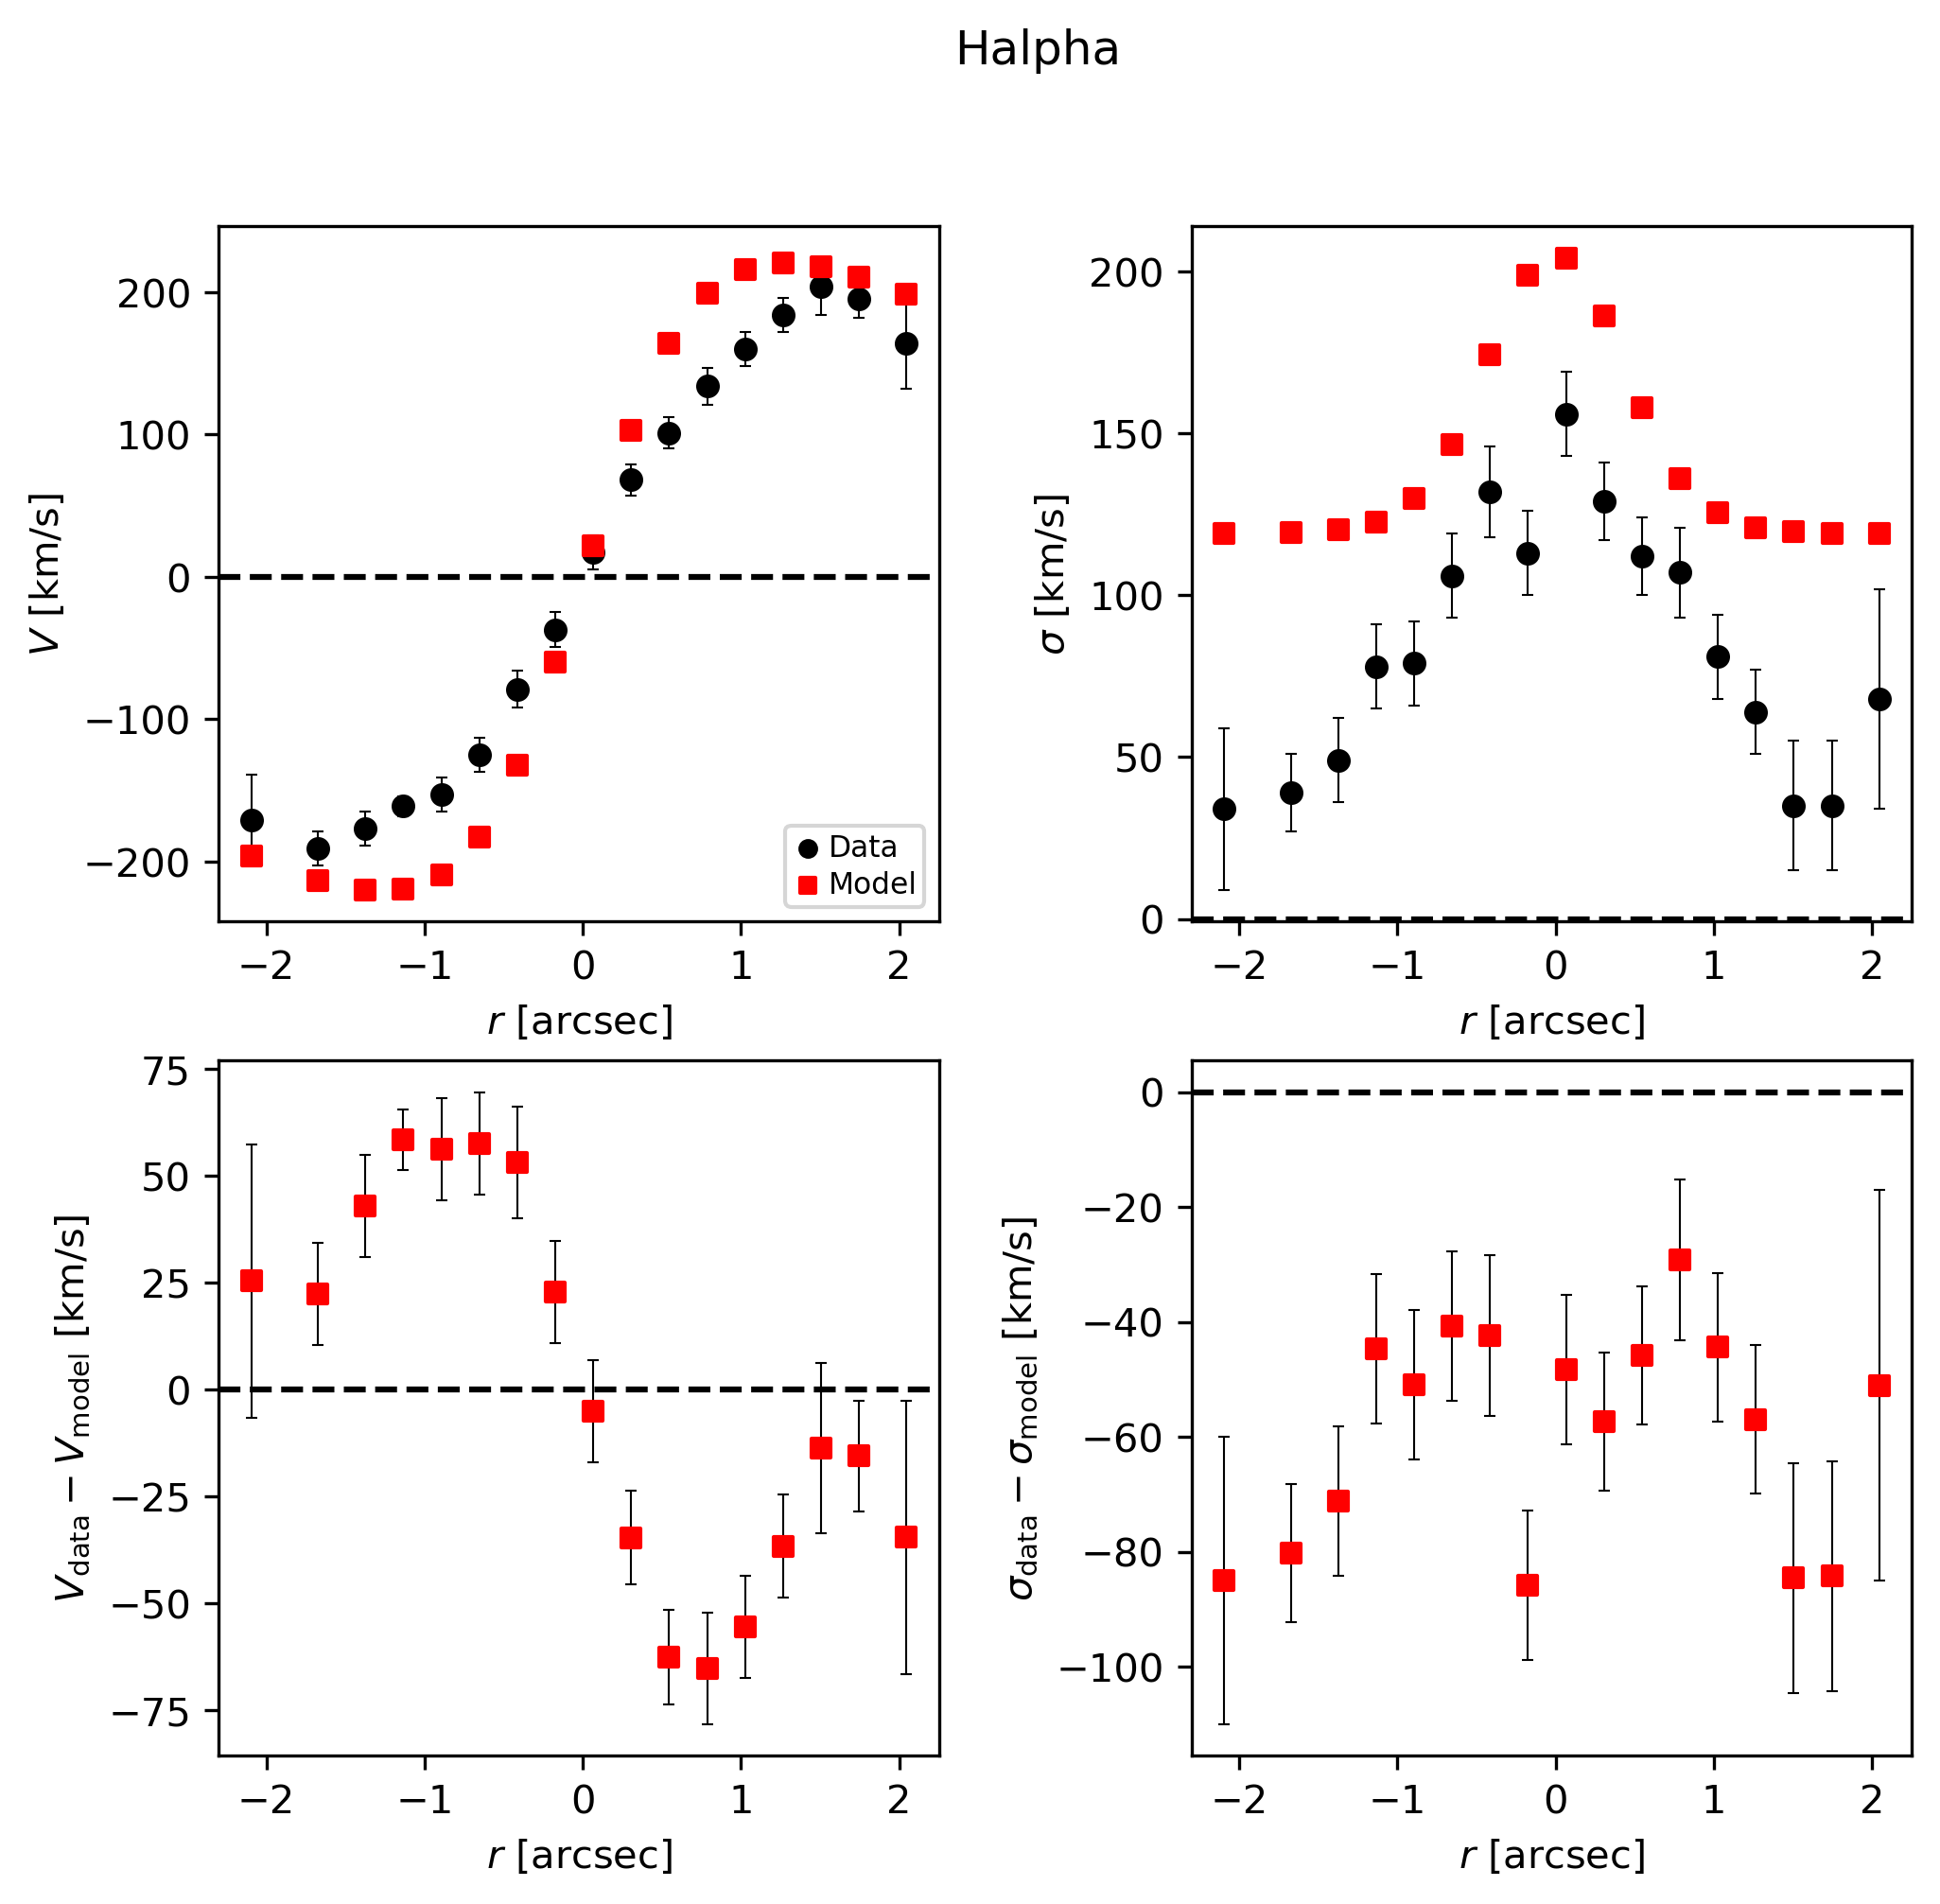

In [41]:
# Look at best-fit:
filepath = outdir_mcmc+"EGS4_24985_mcmc_bestfit_Halpha.{}".format(plot_type)
Image(filepath, width=600)

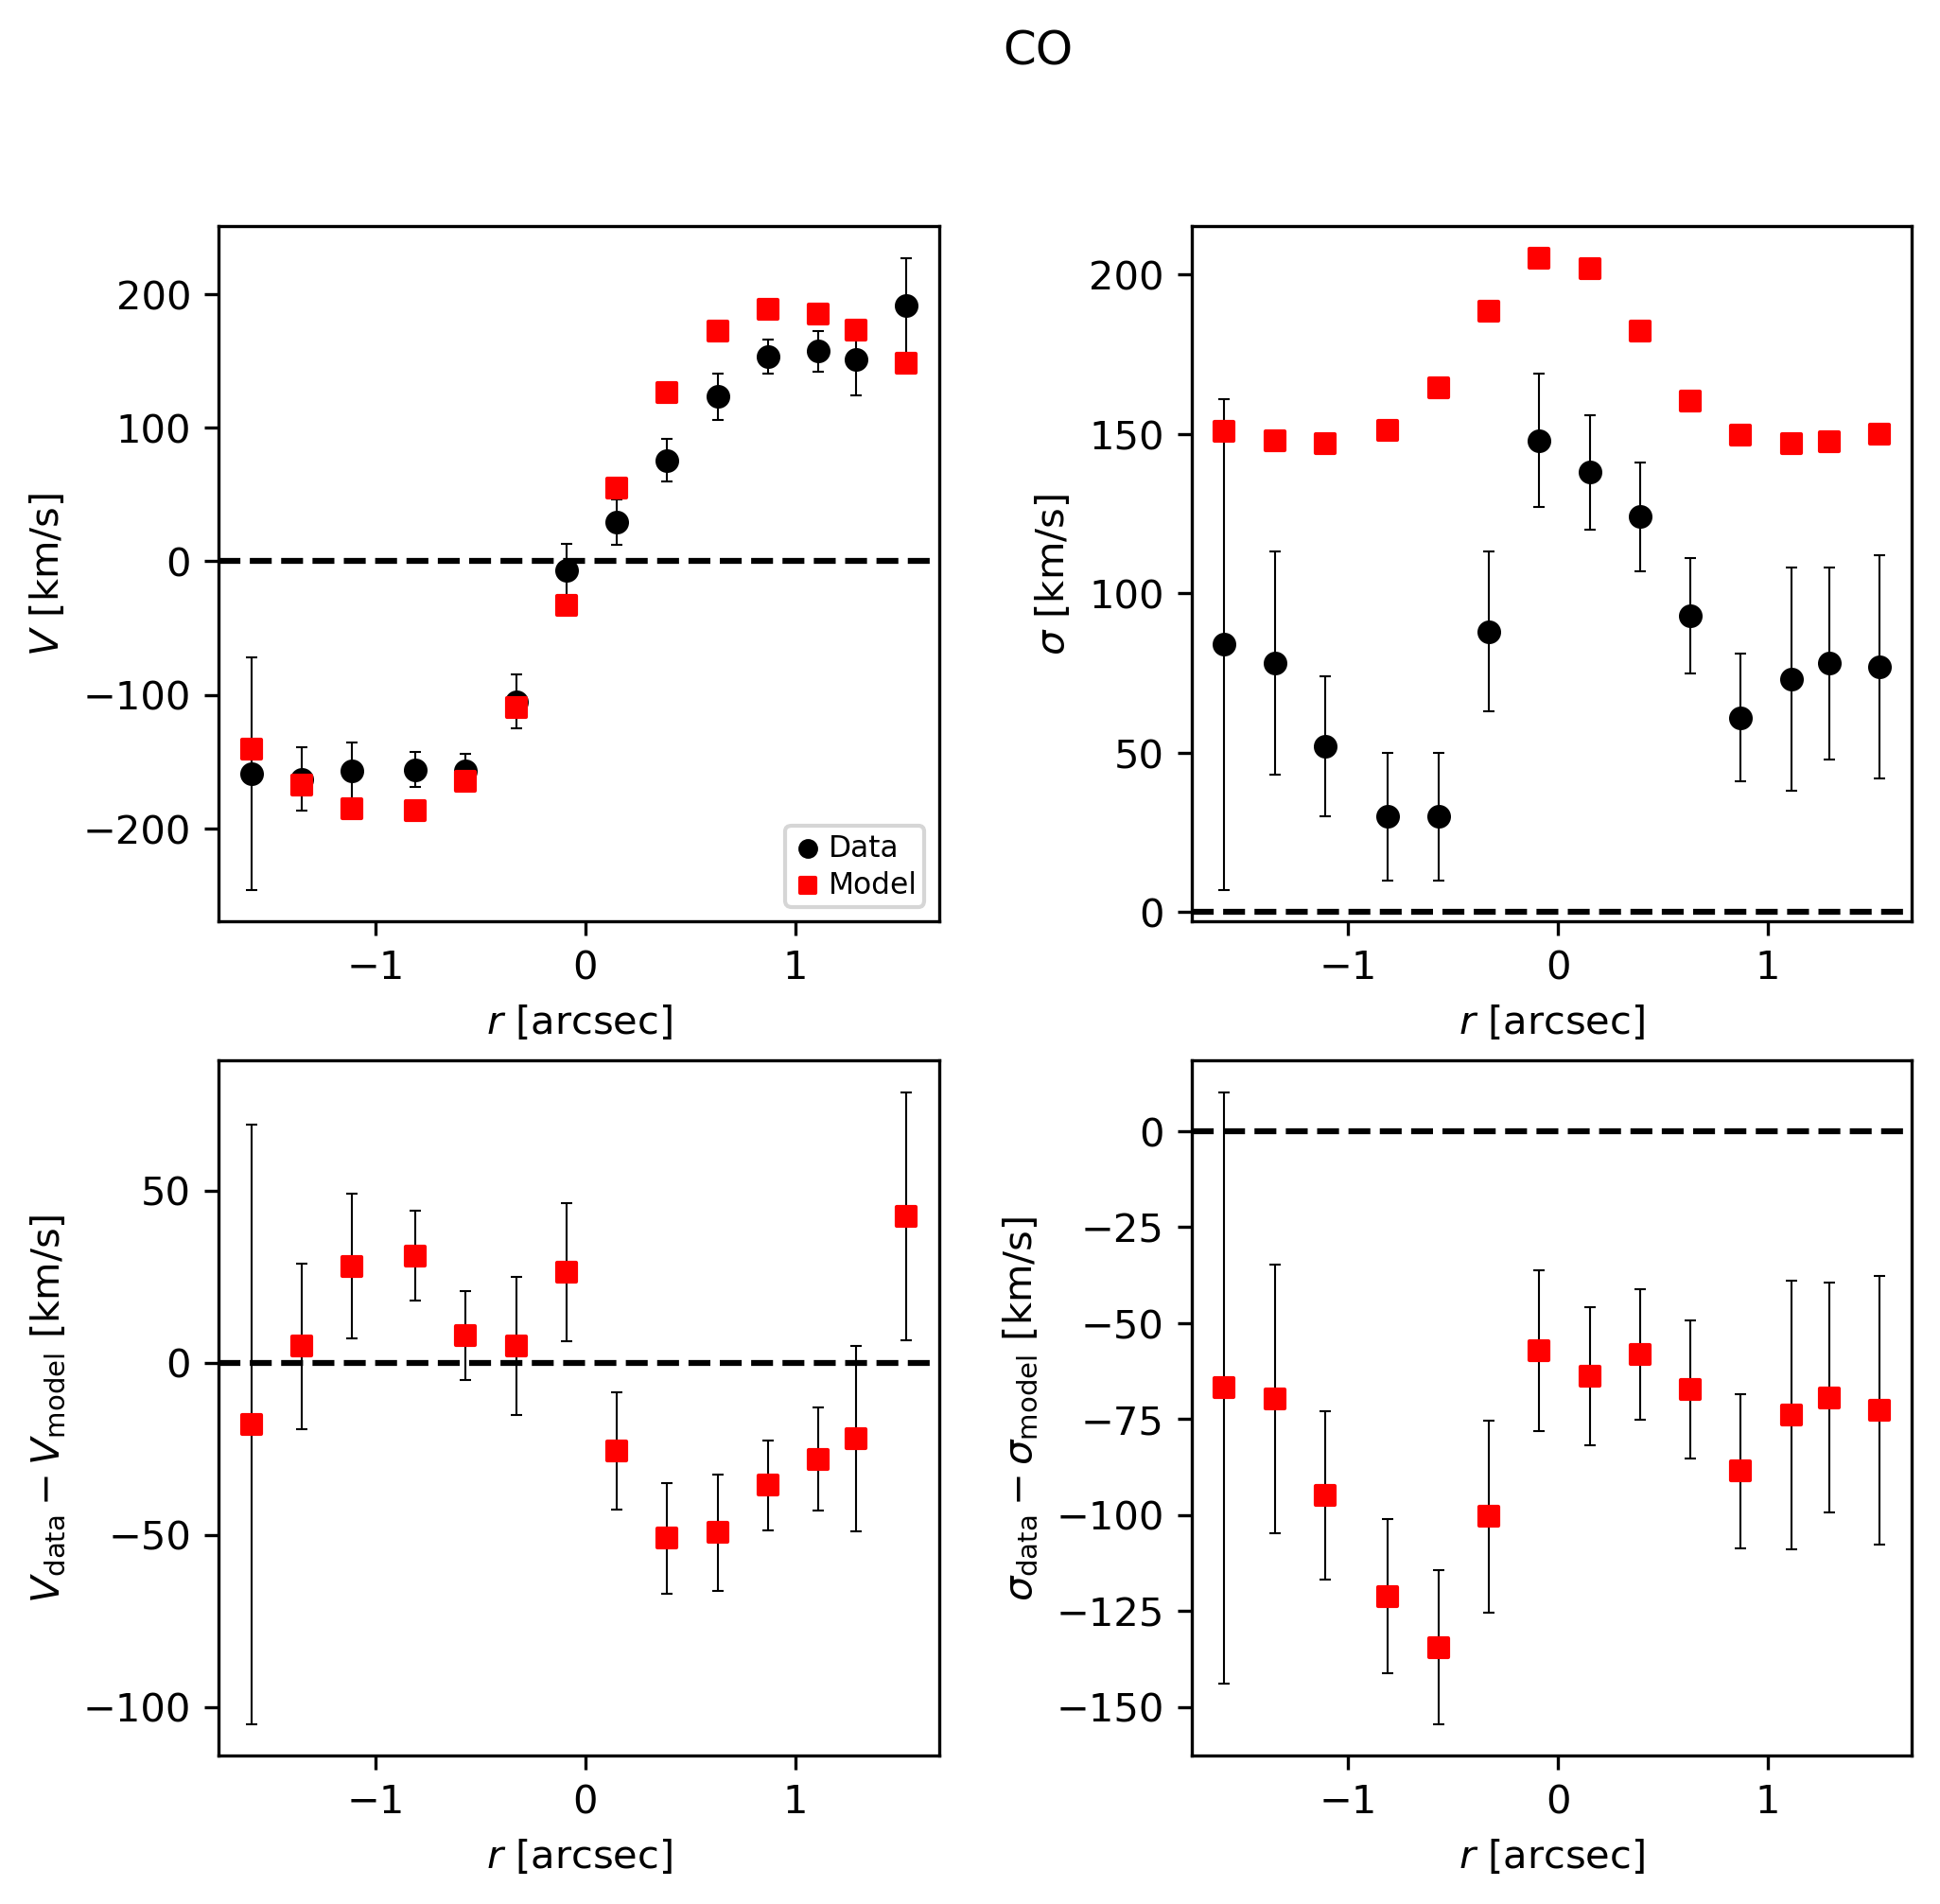

In [42]:
# Look at best-fit:
filepath = outdir_mcmc+"EGS4_24985_mcmc_bestfit_CO.{}".format(plot_type)
Image(filepath, width=600)

**Sampler "corner" plot**
- The "best-fit" MAP (by default taken to be the peak of each marginalized parameter posterior, independent of the other parameters) is marked with the solid blue line. 
  * However, the MAP can also be found by jointly analyzing two or more parameters' posterior space. <p>
       *(&rarr; see the example in the :ref:`1D example fit <dysmalpy_example_fit_1D.ipynb>` tutorial)*
- Check to see that your Gaussian prior centers are marked in orange in the appropriate rows/columns (if any Gaussian priors are used).
- The vertical dashed black lines show the 2.275%, 15.865%, 84.135%, 97.725% percentile intervals for the marginalized posterior for each parameter. 
- The vertical dashed purple lines show the shortest $1\sigma$ interval, determined from the marginalized posterior for each parameter independently. 

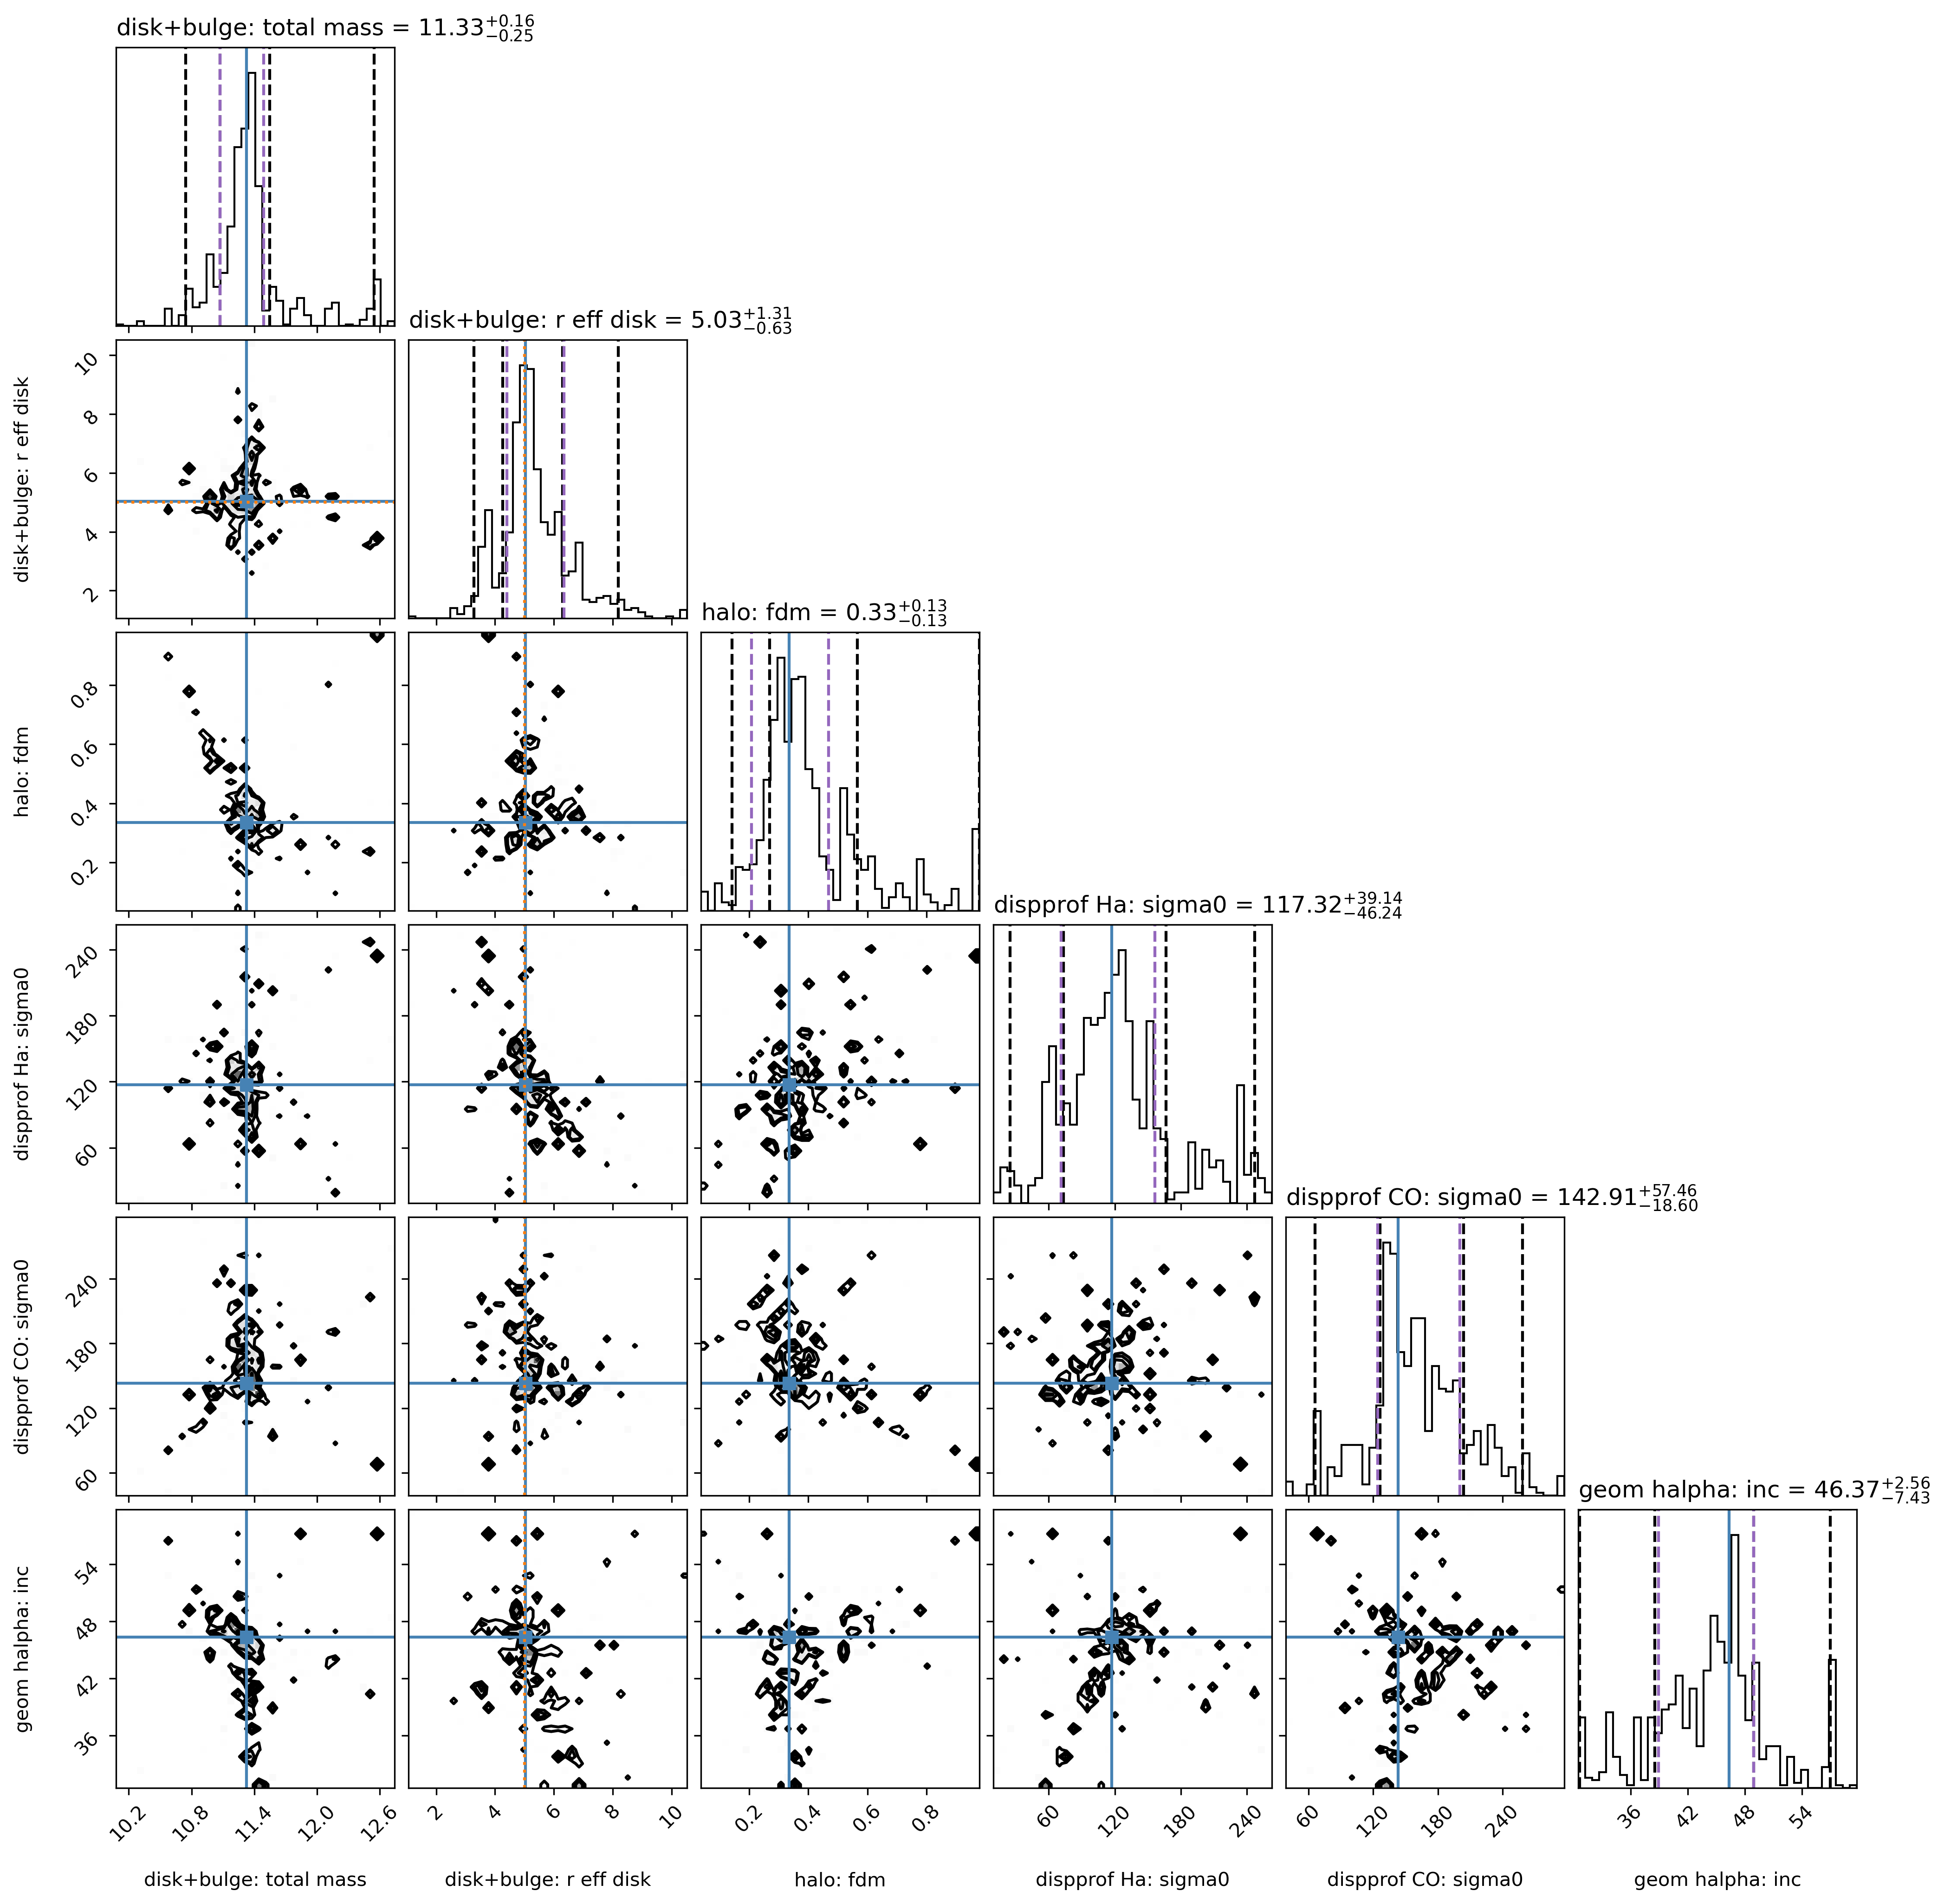

In [43]:
# Look at corner:
filepath = outdir_mcmc+"EGS4_24985_mcmc_param_corner.{}".format(plot_type)
Image(filepath, height=620)

---------

## A real MCMC example ##

In the interest of time, let's look at some results calculated previously, using 1000 walkers, 175 burn-in steps, and 200 steps.

Using **190 threads**, it took about **21 minutes** to run the MCMC fit.

First, you need to download the sampler from:

https://www.mpe.mpg.de/resources/IR/DYSMALPY/dysmalpy_optional_extra_files/MCMC_full_run_nw1000_ns200_a5.tar.gz

Decompress it in your preferred path (e.g.: /path/to/your/directory) and then set an environment variable to access that directory from this notebook. You can do that from the terminal running:

export DATADIR=/path/to/your/directory

Or, you can simply run the bash command from within the notebook as:

%env FULL_MCMC_RUNS_DATADIR=/path/to/your/directory

In [44]:
# A working example using the path of one of the maintainers:
%env FULL_MCMC_RUNS_DATADIR=/Users/jespejo/Dropbox/Postdoc/Data/dysmalpy_test_examples/JUPYTER_OUTPUT_1D_multiobs_full/

env: FULL_MCMC_RUNS_DATADIR=/Users/jespejo/Dropbox/Postdoc/Data/dysmalpy_test_examples/JUPYTER_OUTPUT_1D_multiobs_full/


In [45]:
# Now, add the environment variable to retrieve the data 
_full_mcmc_runs = os.getenv('FULL_MCMC_RUNS_DATADIR')

:::{admonition} Note
We used moment extraction for the model 2D profile extraction, as this 
does not seem to change the result much compared to gaussian extraction 
(as the observed maps were derived). This is likely because the extraction 
is over single pixels, so there is less complex line shape mixing 
as found in 1D extractions.

If this fit is done using a gaussian extraction, exactly following 
the data extraction method, it is generally slower.

When performing fits using moment extraction on data that was gaussian extracted, 
it is worth considering whether this is a reasonable thing to be doing. 
(Or at least check the final results with a gaussian extraction to see if there 
are systematic differences between the moment and gaussian maps.)
:::

In [46]:
outdir_mcmc_full = _full_mcmc_runs + 'MCMC_full_run_nw1000_ns200_a5/'

### Examine results: ###

Helpful for:
  - replotting
  - reanalyzing chain (eg, jointly constraining some posteriors)

**Reload the galaxy, results files:**

In [47]:
f_galmodel = outdir_mcmc_full + 'EGS4_24985_model.pickle'
f_mcmc_results =  outdir_mcmc_full + 'EGS4_24985_mcmc_results.pickle'

#----------------------------------------
## Fix module import
import sys
from dysmalpy import fitting_wrappers
sys.modules['fitting_wrappers'] = fitting_wrappers
#----------------------------------------

gal, mcmc_results = fitting.reload_all_fitting(filename_galmodel=f_galmodel, 
                            filename_results=f_mcmc_results, fit_method='mcmc')

**If necessary, also reload the sampler chain:**

In [48]:
f_sampler =  outdir_mcmc_full + 'EGS4_24985_mcmc_sampler.{}'.format(ftype_sampler)
mcmc_results.reload_sampler(filename=f_sampler)

FitResults.reload_sampler_results()


**Plot the best-fit results:**

In [ ]:
mcmc_results.plot_results(gal)

#### Results report: ####

In [ ]:
# Print report
print(mcmc_results.results_report(gal=gal))

**Or save results report to file:**

In [ ]:
# Save report to file:
f_mcmc_report = outdir_mcmc + 'mcmc_fit_report.txt'
mcmc_results.results_report(gal=gal, filename=f_mcmc_report)